## Import Package/Library

In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

## Data Preprocessing

### Load Data

In [3]:
df = pd.read_excel('dataset_tanaman_papaya.xlsx', sheet_name='Simple Data')

### EDA

In [4]:
df.head()

,Time,Date,Intensitas Cahaya,Kelembaban Tanah,Humidity,Temperature,Bulan
0,20:14:44,27/05/2025,2017,4003,0.91,"28,50°C",4.3808
1,20:14:44,27/05/2025,2032,4054,0.91,"28,50°C",4.4213
2,20:14:45,27/05/2025,2027,4021,0.91,"28,50°C",4.3998
3,20:14:45,27/05/2025,2010,4066,0.91,"28,50°C",4.4053
4,20:14:45,27/05/2025,1936,4023,0.91,"28,50°C",4.3098


> Data diatas memberikan gambaran visual pertama tentang bagaimana data Anda tersusun. Kita bisa langsung melihat nama-nama kolom seperti Intensitas Cahaya, Temperature, dll., beserta contoh isinya. Dari sini kita bisa melihat format data awal, contohnya kolom Temperature yang berisi teks "28,50°C".


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10359 entries, 0 to 10358
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time               10359 non-null  object 
 1   Date               10359 non-null  object 
 2   Intensitas Cahaya  10359 non-null  int64  
 3   Kelembaban Tanah   10359 non-null  int64  
 4   Humidity           10359 non-null  float64
 5   Temperature        10359 non-null  object 
 6   Bulan              10359 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 566.6+ KB


> - Dari kode diatas didapatkan bahwa data terdiri dari 10359 baris dan 7 kolom.
- Kolom "Non-Null Count" menunjukkan semua baris terisi penuh (10359 non-null).
- Kolom Temperature terdeteksi sebagai object (teks/string), bukan angka. Model matematika tidak bisa mengolah teks, jadi ini mengonfirmasi bahwa langkah pembersihan data yang kita lakukan untuk kolom Temperature itu wajib.

In [6]:
df.describe()

,Intensitas Cahaya,Kelembaban Tanah,Humidity,Bulan
count,10359.000000,10359.000000,10359.000000,10359.000000
mean,1356.603437,2033.608746,0.729141,2.752419
std,369.817785,387.271529,0.197699,0.422057
min,199.000000,675.000000,0.210000,1.841700
25%,1203.000000,1827.000000,0.660000,2.574900
50%,1211.000000,1927.000000,0.790000,2.661900
75%,1383.000000,2224.000000,0.890000,2.745950
max,4095.000000,4095.000000,0.930000,6.505600


> - Dari kode dan hasil diatas kita bisa melihat rentang nilai dari setiap sensor. Contohnya, Intensitas Cahaya berkisar dari 0 hingga 39188.
- Setiap fitur memiliki skala yang sangat berbeda (Kelembaban Tanah dalam ribuan, Humidity di bawah 1). Ini mengonfirmasi bahwa langkah normalisasi/scaling sangat penting agar tidak ada satu fitur yang mendominasi proses training model.
- Temperature tidak ada di tabel ini, yang sekali lagi membuktikan bahwa ia belum dianggap sebagai angka.

In [7]:
df.isnull().sum()

,0
Time,0
Date,0
Intensitas Cahaya,0
Kelembaban Tanah,0
Humidity,0
Temperature,0
Bulan,0


> Kode diatas digunakan untuk menghitung jumlah data yang kosong (null) di setiap kolom. Hasilnya adalah 0 untuk semua kolom.

### Membersihkan data

In [8]:
if df['Temperature'].dtype == 'object':
    df['Temperature'] = df['Temperature'].str.replace('°C', '', regex=False).str.replace(',', '.').astype(float)

> Kode diatas bertujuan untuk mengubah data di kolom Temperature dari format teks (contoh: "28,50°C") menjadi format angka yang bisa dihitung (contoh: 28.5). Model matematika tidak bisa mengerti teks, jadi langkah ini wajib dilakukan.

In [9]:
if 'Humidity' in df.columns and df['Humidity'].max() <= 1.0:
    df['Humidity'] = df['Humidity'] * 100

> Kode diatas bertujuan untuk mengubah skala Humidity dari format rasio (nilai antara 0 dan 1, contoh: 0.91) menjadi format persentase yang lebih mudah dibaca (contoh: 91.0).

### Membuat Target Simulasi

In [10]:
np.random.seed(42)
base_harvest_days = 150
df['days_to_harvest'] = base_harvest_days \
                      - (df['Temperature'] - df['Temperature'].mean()) * 2 \
                      - (df['Intensitas Cahaya'] - df['Intensitas Cahaya'].mean()) / 100 \
                      + abs(df['Humidity'] - df['Humidity'].mean()) * 0.1 \
                      + np.random.normal(0, 3, len(df))
df['days_to_harvest'] = df['days_to_harvest'].round().astype(int)

>- Blok kode ini bertujuan untuk membuat kolom target days_to_harvest secara artifisial. Langkah ini diperlukan karena dataset asli hanya berisi data fitur (sensor) dan tidak memiliki data target (label) yang akan diprediksi.
- Model supervised learning membutuhkan target untuk bisa belajar, sehingga simulasi ini berfungsi sebagai placeholder realistis selama tahap pengembangan dan prototyping.
- Blok kode ini hanya untuk tahap development. Ketika data panen riil dari lapangan sudah tersedia, seluruh blok kode ini harus dihapus dan digantikan dengan kolom days_to_harvest yang asli dari dataset baru tersebut.

### Fitur dan Target

In [11]:
features = ['Temperature', 'Humidity', 'Kelembaban Tanah', 'Intensitas Cahaya']
target = 'days_to_harvest'

X = df[features]
y = df[target]

> Kode diatas adalah langkah dalam persiapan data untuk machine learning, yaitu memisahkan antara fitur (variabel input) dan target (variabel output).

### Split Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> Data dibagi menjadi:
- 20% untuk testing
- 80% untuk training

### Normalisasi Data

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

>  Tujuan scaling adalah untuk menyamakan skala semua fitur agar semuanya memiliki "bobot" yang adil di mata model. Ini membuat proses training menjadi lebih cepat, lebih stabil, dan sering kali menghasilkan model yang lebih akurat.

## Modeling dengan Keras

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(features),)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 17184.1113 - mean_absolute_error: 121.5606 - val_loss: 592.0071 - val_mean_absolute_error: 17.7779
Epoch 2/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 546.6837 - mean_absolute_error: 15.5175 - val_loss: 190.1746 - val_mean_absolute_error: 9.2066
Epoch 3/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163.1824 - mean_absolute_error: 8.5381 - val_loss: 74.2752 - val_mean_absolute_error: 5.9783
Epoch 4/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 67.1439 - mean_absolute_error: 5.4872 - val_loss: 30.0347 - val_mean_absolute_error: 3.8964
Epoch 5/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29.8917 - mean_absolute_error: 3.7621 - val_loss: 18.8086 - val_mean_absolute_error: 3.1579
Epoch 6/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18.7490 - mean_absolute_error: 3.1213 - val_loss: 13.6638 - val_mean_absolute_error: 2.8516
Epoch 7/200
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.2147 - 

> Log training diatas menunjukkan proses pembuatan model yang sehat, efisien, dan sukses, menghasilkan model dengan performa yang terukur dan akurasi yang sangat baik.
- Pelatihan berhenti di epoch ke-51. Ini bukan kegagalan, justru ini adalah keberhasilan. Callback EarlyStopping dengan cerdas mendeteksi bahwa model sudah tidak bisa belajar lebih baik lagi (karena val_loss tidak kunjung membaik secara signifikan), lalu menghentikan proses untuk menghemat waktu dan mencegah overfitting.
- Dari log diatas, kita bisa melihat bahwa performa terbaik model pada data validasi (yang mensimulasikan data baru) memiliki Mean Absolute Error sekitar 2.46 - 2.5 hari.
- tidak ada tanda overfitting karena val_loss tidak pernah melambung tinggi secara tidak terkendali sementara loss terus turun.

## Evaluasi Model

In [18]:
print("\n--- Hasil Evaluasi Model (Keras) ---")
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred = model.predict(X_test_scaled).flatten()
r2 = r2_score(y_test, y_pred)
print(f"Model selesai dilatih dalam {len(history.history['loss'])} epochs.")
print(f"Mean Absolute Error (MAE): {mae:.2f} hari")
print(f"R2 Score: {r2:.2%}")


--- Hasil Evaluasi Model (Keras) ---
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model selesai dilatih dalam 51 epochs.
Mean Absolute Error (MAE): 2.45 hari
R2 Score: 96.33%


> - Proses training berhenti setelah 51 putaran, bukan sampai 200. Ini adalah hasil yang bagus. Ini menunjukkan EarlyStopping bekerja dengan efisien, menghentikan training karena model sudah mencapai performa puncaknya dan tidak bisa belajar lebih baik lagi.
- Secara rata-rata, prediksi yang dibuat oleh model memiliki kesalahan (meleset) sekitar 2.45 hari dari waktu panen yang sebenarnya. Untuk kasus prediksi panen yang bisa memakan waktu berbulan-bulan, kesalahan yang hanya 2-3 hari ini tergolong sangat kecil dan akurat.
- R2 Score: 96.33%. artinya, 96.33% dari variasi atau perubahan pada waktu panen (days_to_harvest) dapat dijelaskan oleh fitur-fitur sensor (Temperature, Humidity, dll.) yang digunakan. ini menunjukkan bahwa model memiliki kemampuan prediksi yang luar biasa kuat. Ada hubungan yang sangat erat antara input yang diberikan dan output yang dihasilkan model.

## Visualisasi

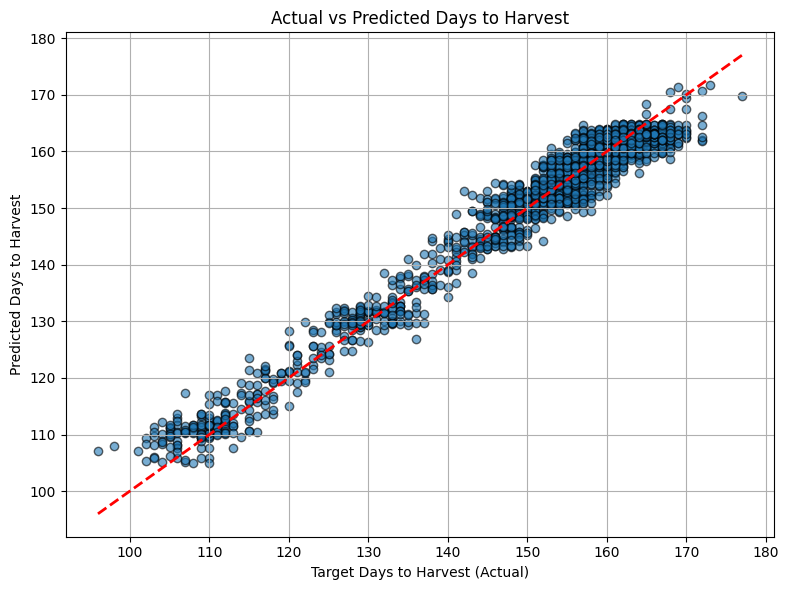

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Target Days to Harvest (Actual)')
plt.ylabel('Predicted Days to Harvest')
plt.title('Actual vs Predicted Days to Harvest')
plt.grid(True)
plt.tight_layout()
plt.show()

> Grafik diatas menunjukkan hasil yang sangat baik.
- Hampir semua titik biru menempel atau berada sangat dekat dengan garis merah.Ini membuktikan bahwa Prediksi Sangat Mendekati Kenyataan.
-  Titik-titik membentuk sebuah pola garis lurus yang sangat jelas. Ini menandakan bahwa jika nilai aktualnya naik, nilai prediksinya juga akan naik secara konsisten.
- Jarak rata-rata yang pendek dari setiap titik ke garis merah adalah MAE (Mean Absolute Error) Anda yang rendah (sekitar 2.45 hari).
- Kumpulan titik yang membentuk garis lurus yang rapat ini adalah cerminan dari R² Score Anda yang tinggi (96.33%).

## Save Model

In [20]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133507947220624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947221776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947221008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947222160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947218512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947218320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947218896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133507947221584: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Convert model ke TFJS

In [27]:
saved_model_dir = "/content/saved_model"
output_tfjs_dir = "tfjs_model"

In [28]:
tfjs.converters.convert_tf_saved_model(
    saved_model_dir=saved_model_dir,
    output_dir=output_tfjs_dir
)